In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

# import the non-gaussianity extension
from nongaussianity_ext import *

seed    = 42
ns      = 10
nocc    = ns // 2 - 1
la      = ns // 2
lb      = ns - la
dimA    = 2**(la)
dimB    = 2**(lb)
ordered = True
rng     = np.random.default_rng(seed=seed)

logger.info(f"Creating the system of Ns={ns} orbitals, Nocc={nocc}. Subsystem: La={la}, Lb={lb}", lvl=0, color='blue')

19_08_2025_09-41_47 [INFO] Log file created: ./log/QES_19_08_2025_09-41_47.log
19_08_2025_09-41_47 [INFO] Log level set to: info
19_08_2025_09-41_47 [INFO] ############Global logger initialized.############
19_08_2025_09-41_47 [INFO] JAX is not available. Using NumPy as the active backend.
19_08_2025_09-41_47 [INFO] **************************************************
19_08_2025_09-41_47 [INFO] Backend Configuration:
19_08_2025_09-41_47 [INFO] 		NumPy Version: 2.1.3
19_08_2025_09-41_47 [INFO] 		SciPy Version: 1.15.2
19_08_2025_09-41_47 [INFO] 		JAX Version: Not Available
19_08_2025_09-41_47 [INFO] 		Active Backend: numpy
19_08_2025_09-41_47 [INFO] 			JAX Available: False
19_08_2025_09-41_47 [INFO] 			Default Seed: 42
19_08_2025_09-41_47 [INFO] 		NumPy Backend Details:
19_08_2025_09-41_47 [INFO] 				Main Module: numpy
19_08_2025_09-41_47 [INFO] 				Random Module: Generator
19_08_2025_09-41_47 [INFO] 				SciPy Module: scipy
19_08_2025_09-41_47 [INFO] 		Active Data Types:
19_08_2025_09-41_4

19_08_2025_09-51_46 [INFO] 	->[AubryAndre] Building Hamiltonian (Type: Quadratic)...
19_08_2025_09-51_46 [INFO] 		->[AubryAndre] Initialization completed in 0.000043 seconds
19_08_2025_09-51_46 [INFO] 		->[AubryAndre] Building AA Hamiltonian...
19_08_2025_09-51_46 [INFO] 		->[AubryAndre] AA Hamiltonian built.
19_08_2025_09-51_46 [INFO] 	->[AubryAndre] Hamiltonian matrix built in 0.001211 seconds.
Hamiltonian: AA(ns=10,J=1.0,lambda=0.500,beta=0.707,phi=0.000)


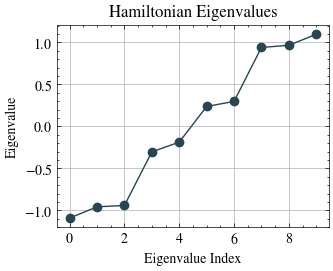

array([-1.09095375, -0.95787923, -0.94134834, -0.3032409 , -0.187222  ,
        0.23728071,  0.29763489,  0.94034771,  0.96567441,  1.0973757 ])

In [13]:
hamil = create_hamiltonian(
    ns          = 10,
    # model_type  = ModelHamiltonians.SYK2,
    # model_type  = ModelHamiltonians.FreeFermions,
    model_type  = ModelHamiltonians.AubryAndre,
    t           = 1.0,
    seed        = seed,
    dtype       = np.float64,
    J           = 1.0,
    lmbd        = 0.5,
    beta        = 1.0 / np.sqrt(2.0)
)
hamil.build(verbose=True, use_numpy=True)
hamil.diagonalize()
print(f"Hamiltonian: {hamil}")
plt.plot(np.arange(hamil._nh), np.real(hamil.eig_val), marker='o')
plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue")
plt.title("Hamiltonian Eigenvalues")
plt.grid()
plt.show()

hamil.eig_val

In [14]:
arrangement         = range(ns) # orbitals 0..Ns-1
o_en                = choose_orbitals(  arrangement     = arrangement, 
                                        filling         = nocc,
                                        hamil           = hamil,
                                        number          = 5 if hamil.ns > 10 else None,
                                        e_window        = (-0.5, 0.5),
                                        rng             = rng,
                                        constraints     = [q_constraint(hamil.ns, 0.0, 1e-5)]
                                    )

o_en, len(o_en)

([(array([4, 8, 2, 6]), 0.13473896022238008),
  (array([4, 2, 5, 9]), 0.206086072989208),
  (array([4, 6, 9, 1]), 0.24990935721990493),
  (array([8, 2, 9, 1]), 0.16382253293058713),
  (array([2, 6, 9, 3]), 0.15042135303102455)],
 5)

In [15]:
start_block     = time.time()
transform_pc    = prepare_trans_mat_orbitals(hamil, occ=la, ordered=ordered)
W, W_A, W_A_CT  = transform_pc.W, transform_pc.W_A(), transform_pc.W_A_CT()
logger.info(f"Shape of W: {W.shape}, dtype: {W.dtype}", lvl=2)
logger.info(f"Shape of W_A: {W_A.shape}", lvl=3)
logger.info(f"Shape of W_A_CT: {W_A_CT.shape}", lvl=3)
logger.info(f"Execution time: {time.time() - start_block:.4e} seconds", lvl=3, color = 'yellow')

19_08_2025_09-51_48 [INFO] 		->Shape of W: (10, 10), dtype: float64
19_08_2025_09-51_48 [INFO] 			->Shape of W_A: (10, 5)
19_08_2025_09-51_48 [INFO] 			->Shape of W_A_CT: (5, 10)
19_08_2025_09-51_48 [INFO] 			->Execution time: 2.0692e-03 seconds


In [16]:
# Performance measurement
start_total             = time.time()

# test the extractor
if ns < 9:
    # Generate a random mask for the lattice positions
    if ordered:
        mask_a              = np.arange(la)
    else:
        mask_a              = np.sort(rng.choice(np.arange(hamil.ns), la, replace=False))
        
    mask_b                  = np.setdiff1d(np.arange(hamil.ns), mask_a)
    order                   = tuple(mask_a) + tuple(mask_b)
    mask_a_onehot           = Extractor.to_one_hot(mask_a, hamil.ns)
    mask_b_onehot           = Extractor.to_one_hot(mask_b, hamil.ns)
    
    # tester
    state_to_extract        = rng.integers(0, 2**hamil.ns)
    state_to_extract_str    = int2binstr(state_to_extract, hamil.ns)
    state_to_extract_col    = Extractor.colorize_extractor(state_to_extract_str, mask_a, mask_b, logger)
    start_block             = time.time()
    #
    mask_a_extractor        = Extractor.make_extractor(mask_a, size=hamil.ns, backend='numba_vnb')
    mask_b_extractor        = Extractor.make_extractor(mask_b, size=hamil.ns, backend='numba_vnb')
    state_ext_a             = mask_a_extractor(state_to_extract)
    state_ext_b             = mask_b_extractor(state_to_extract)
    
    logger.info(f"Mask for the lattice positions on A: {mask_a}", lvl=0)
    logger.info(f"Mask for the lattice positions on A (one-hot): {mask_a_onehot}", lvl=1)
    logger.info(f"Mask for the lattice positions on B: {mask_b}", lvl=0)
    logger.info(f"Mask for the lattice positions on B (one-hot): {mask_b_onehot}", lvl=1)
    logger.info(f"Order of the mask: {order}", lvl=1)
    logger.title("Small test", desired_size=50, fill='+', color='green')
    logger.info(f"State to extract: {state_to_extract}:{state_to_extract_col}", lvl=1)
    logger.info(f"Mask for the lattice positions on A (extracted): {state_ext_a}:{int2binstr(state_ext_a, nocc)}", lvl=2, color='green')
    logger.info(f"Mask for the lattice positions on B (extracted): {state_ext_b}:{int2binstr(state_ext_b, hamil.ns - nocc)}", lvl=2, color='white')
    logger.info(f"Execution time: {time.time() - start_block:.4e} seconds", lvl=2)
    logger.title("Finished", desired_size=50, fill='+', color='green')

# # Initialize lists to store results
# entropies_correlation   = []
# entropies_many_body     = []

num_samples     = len(o_en)
entropies       = []
entropies_mb    = []
for ii, (comb, en) in enumerate(o_en):
    logger.info(f"Processing sample {ii + 1}/{num_samples}, E={en:.3f}", lvl=1, color='red')
    comb_one_hot            = to_one_hot(comb, hamil.ns)
    start_block             = time.time()
    correlation_matrix      = prepare_corr_matrix_sp(W_A=W_A, W_A_CT=W_A_CT, occ=comb_one_hot)
    print(f"Shape of the correlation matrix: {correlation_matrix.shape}")
    start_block_2           = time.time()
    
    # diagonalize the correlation matrix
    corr_val, _             = np.linalg.eigh(correlation_matrix)
    entropy_correlation     = Entropy.entropy(corr_val, typek=Entropy.Entanglement.SINGLE)
    entropies.append(entropy_correlation)
    logger.info(f"Entropy from single-particle correlation: {entropy_correlation:.4e}", lvl=2, color='green')
    logger.info(f"Execution time: {time.time() - start_block:.4e} seconds", lvl=3, color='yellow')
    logger.info(f"Execution time for correlation matrix calculation: {start_block_2 - start_block:.4e} seconds", lvl=4, color='yellow')

    if hamil.ns <= 10:
        start_block             = time.time()
        many_body_state         = hamil.many_body_state(occupied_orbitals=comb)
        start_block_2           = time.time()
        schmidt_values          = Dens.schmidt_numpy(many_body_state, dimA = dimA, dimB = dimB, eig = False)[0]
        entropy_many_body       = Entropy.vn_entropy(schmidt_values)
        entropies_mb.append(entropy_many_body)
        logger.info(f"Entropy from many-body state: {entropy_many_body:.4e}", lvl=2, color='blue')
        logger.info(f"Execution time: {time.time() - start_block:.4e} seconds", lvl=3, color='yellow')
        logger.info(f"Execution time for many body state preparation: {start_block_2 - start_block:.4e} seconds", lvl=4, color='yellow')
        logger.info(f"Execution time for density matrix calculation: {time.time() - start_block_2:.4e} seconds", lvl=4, color='yellow')

    if hamil.ns <= 10:
        # correlation matrix from many-body state
        correlation_matrix_mb   = Corr.corr_from_statevector(many_body_state, ns=hamil.ns, subtract_identity=True)
        correlation_matrix_mb   = (correlation_matrix_mb[:la, :la])  # ensure it's real
        
        # diagonalize the correlation matrix
        corr_val, _             = np.linalg.eigh(correlation_matrix_mb)
        purity                  = np.sum(corr_val**2)
        fourth_moment           = np.sum(corr_val**4)
        sixth_moment            = np.sum(corr_val**6)
        entropy_correlation_mb  = Entropy.entropy(corr_val, typek=Entropy.Entanglement.SINGLE)
        entropies_mb.append(entropy_correlation_mb)
        
        logger.info(f"Entropy from many-body correlation: {entropy_correlation_mb:.4e}", lvl=2, color='purple')
        NG, gaussianity, purity, m4, m6 = nongaussianity(eigvals=corr_val, return_stats=True)
        logger.info(f"Nongaussianity: {NG:.4e}, Gaussianity: {gaussianity:.4e}, Purity: {purity:.4e}, M4: {m4:.4e}, M6: {m6:.4e}", lvl=2, color='purple')

19_08_2025_09-51_48 [INFO] 	->Processing sample 1/5, E=0.135
Shape of the correlation matrix: (5, 5)
19_08_2025_09-51_48 [INFO] 		->Entropy from single-particle correlation: 2.5221e+00
19_08_2025_09-51_48 [INFO] 			->Execution time: 7.5102e-04 seconds
19_08_2025_09-51_48 [INFO] 				->Execution time for correlation matrix calculation: 1.8907e-04 seconds
19_08_2025_09-51_48 [INFO] 		->Entropy from many-body state: 2.5221e+00
19_08_2025_09-51_48 [INFO] 			->Execution time: 1.8110e-03 seconds
19_08_2025_09-51_48 [INFO] 				->Execution time for many body state preparation: 1.1990e-03 seconds
19_08_2025_09-51_48 [INFO] 				->Execution time for density matrix calculation: 1.2462e-03 seconds
19_08_2025_09-51_48 [INFO] 		->Entropy from many-body correlation: 2.5221e+00
19_08_2025_09-51_48 [INFO] 		->Nongaussianity: 2.5221e+00, Gaussianity: 1.4452e+00, Purity: 2.9730e-01, M4: 2.1612e-01, M6: 2.0300e-01
19_08_2025_09-51_48 [INFO] 	->Processing sample 2/5, E=0.206
Shape of the correlation matrix: 

In [40]:
# number of states to mix
gamma       = 1

# number of realizations taken from the combinations
n_realiz    = 10

# arrangement of the eigenstates
logger.info(f"Mixing gamma={gamma} states from {len(o_en)} many-body orbitals", lvl=2, color='red')
o_arrange   = np.arange(len(o_en))
rng.shuffle(o_arrange)  # shuffle the arrangement to get different combinations
o_combs     = itertools.combinations(o_arrange, gamma)
for ii, comb_indices in enumerate(itertools.islice(o_combs, n_realiz)):
    many_body_state = np.zeros(2**hamil.ns, dtype=hamil.dtype)
    logger.info(f"Realization {ii + 1}/{n_realiz}, using combinations: {comb_indices}", lvl=2, color='red')
    if hamil.dtype == np.complex128:
        coefficients = rng.normal(size=gamma) + 1j * rng.normal(size=gamma)
    else:
        coefficients = rng.normal(size=gamma)
    coefficients = coefficients / np.linalg.norm(coefficients)
    for jj, comb_idx in enumerate(comb_indices):
        comb, en           = o_en[comb_idx]
        print(comb)
        many_body_state   += hamil.many_body_state(occupied_orbitals=comb) * coefficients[jj]
        
    # correlation matrix
    corr_matrix_mb          = Corr.corr_from_statevector(many_body_state, ns=hamil.ns, subtract_identity=True)
    corr_val, _             = np.linalg.eigh(correlation_matrix_mb)
    NG, gaussianity, purity, m4, m6 = nongaussianity(eigvals=corr_val, return_stats=True)
    logger.info(f"Realization {ii}: NG={NG}, Gaussianity={gaussianity}, Purity={purity}, m4={m4}, m6={m6}", lvl=3)

    # density matrix
    schmidt_values      = Dens.schmidt_numpy(many_body_state, dimA = dimA, dimB = dimB, eig = False)[0]
    entropy_many_body   = Entropy.vn_entropy(schmidt_values)
    logger.info(f"Realization {ii}: Entropy from many-body state: {entropy_many_body:.4e}", lvl=3, color='blue')
    

19_08_2025_10-08_00 [INFO] 		->Mixing gamma=1 states from 5 many-body orbitals
19_08_2025_10-08_00 [INFO] 		->Realization 1/10, using combinations: (np.int64(3),)
[8 2 9 1]
19_08_2025_10-08_00 [INFO] 			->Realization 0: NG=1.8793207224673742, Gaussianity=0.39791520144145687, Purity=0.5173212740263013, m4=0.3741118842826305, m6=0.3047382838997774
19_08_2025_10-08_00 [INFO] 			->Realization 0: Entropy from many-body state: 1.6337e+00
19_08_2025_10-08_00 [INFO] 		->Realization 2/10, using combinations: (np.int64(4),)
[2 6 9 3]
19_08_2025_10-08_00 [INFO] 			->Realization 1: NG=1.8793207224673742, Gaussianity=0.39791520144145687, Purity=0.5173212740263013, m4=0.3741118842826305, m6=0.3047382838997774
19_08_2025_10-08_00 [INFO] 			->Realization 1: Entropy from many-body state: 1.8793e+00
19_08_2025_10-08_00 [INFO] 		->Realization 3/10, using combinations: (np.int64(1),)
[4 2 5 9]
19_08_2025_10-08_00 [INFO] 			->Realization 2: NG=1.8793207224673742, Gaussianity=0.39791520144145687, Purity=0.5